In [1]:
# Importing reqlibraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam 
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy
from keras import metrics
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
train_loc = '/content/drive/MyDrive/archive/Training'
test_loc =  '/content/drive/MyDrive/archive/Testing'

In [3]:
data = ImageDataGenerator(rescale= 1./255)

train_data = data.flow_from_directory(directory = train_loc, 
                                       target_size = (224,224),
                                      )

Found 5712 images belonging to 4 classes.


In [4]:
data = ImageDataGenerator(rescale= 1./255)

test_data = data.flow_from_directory(directory = test_loc, 
                                       target_size = (224,224),
                                      )

Found 1311 images belonging to 4 classes.


In [5]:
train_data.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [6]:
test_data.class_indices


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [7]:
input_shape = (224,224,3)

In [8]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [9]:
def create_model(model_url, num_classes=10):
 
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=input_shape) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [10]:

# Create model
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [11]:
# Compiling the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=2,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data))
                                 

Epoch 1/2
179/179 [==============================] - 717s 4s/step - loss: 0.5109 - accuracy: 0.8167 - val_loss: 0.4139 - val_accuracy: 0.8383
Epoch 2/2
179/179 [==============================] - 35s 193ms/step - loss: 0.2783 - accuracy: 0.9023 - val_loss: 0.3151 - val_accuracy: 0.8749


In [12]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

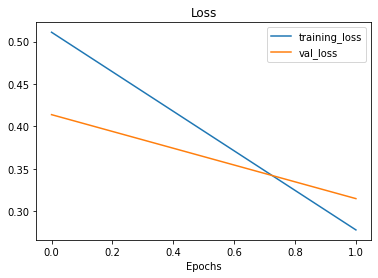

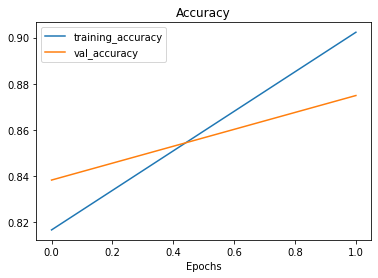

In [13]:
plot_loss_curves(resnet_history)

In [14]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 4)                 8196      
                                                                 
Total params: 23,572,996
Trainable params: 8,196
Non-trainable params: 23,564,800
_________________________________________________________________


In [15]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=2,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data))
                                             

Epoch 1/2
179/179 [==============================] - 44s 197ms/step - loss: 0.5823 - accuracy: 0.7934 - val_loss: 0.4517 - val_accuracy: 0.8101
Epoch 2/2
179/179 [==============================] - 35s 198ms/step - loss: 0.3351 - accuracy: 0.8883 - val_loss: 0.3710 - val_accuracy: 0.8497


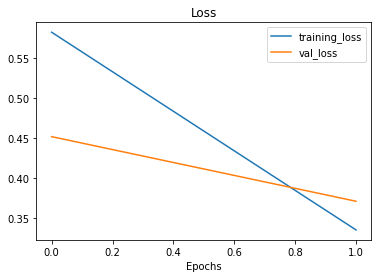

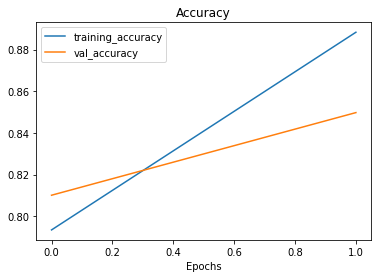

In [16]:

plot_loss_curves(efficientnet_history)

In [23]:
efficientnet_model.save("efficient_net_model.h5")
resnet_model.save("resnet_model.h5")

In [28]:
model_1 = tf.keras.models.load_model(
       ("/content/efficient_net_model.h5"),
       custom_objects={'KerasLayer':hub.KerasLayer})

model_2 = tf.keras.models.load_model(
       ("/content/resnet_model.h5"),
       custom_objects={'KerasLayer':hub.KerasLayer})

In [30]:
import numpy as np

models = [model_1, model_2]


  

In [31]:
def ensemble_predictions(members, testX):
  yhats = [model.predict(testX) for model in members]
  yhats = np.array(yhats)
  # sum across ensemble members
  summed = np.sum(yhats, axis=0)
  # argmax across classes
  result = np.argmax(summed, axis=1)
  return result

In [43]:
result=ensemble_predictions(models,test_data)

41/41 [==============================] - 6s 150ms/step


In [44]:
result


array([2, 1, 2, ..., 2, 0, 0])

In [46]:
result.shape

(1311,)

In [53]:
len(test_data)

41

In [54]:
1311/32

40.96875